In [1]:
! pip install huggingface_hub dotenv

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Improtant
1. Create an acccount at huggingface.co
2. Create an access token with the right to make inference calls
3. Create an .env file in the root directory of your project with the following content:

hf_token=your-huggingface-api-token



- ⚠️ Make sure to add the .env file to your .gitignore to prevent it from being accidentally committed to version control.

In [34]:
import os
from dotenv import load_dotenv
from huggingface_hub import InferenceClient

# Load environment variables from the .env file
load_dotenv()

# Load the Hugging Face token from .env
hf_token = os.getenv('hf_token')

if not hf_token:
    raise EnvironmentError("Hugging Face token (hf_token) is missing in the .env file!")

client = InferenceClient(
    provider="cerebras",
    api_key=hf_token
    )
completion = client.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct",
    messages=[        {
            "role": "user",
            "content": "What is the capital of France?"
        }

    ],

)

print(completion.choices[0].message.content)

The capital of France is Paris.


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Generate a small synthetic sentiment dataset

from time import sleep

sentences = [
    ("The movie had stunning visuals, but the story left me cold.", "negative"),
    ("I didn't hate the product, but I wouldn't buy it again.", "negative"),
    ("Service was slow, but the staff was really friendly and helpful.", "positive"),
    ("Not the worst experience I've had, but I expected much better.", "negative"),
    ("I thought I’d dislike it, but it surprisingly grew on me.", "positive"),
    # ("The food wasn’t great, but the atmosphere made up for it.", "positive"),
    # ("I wouldn’t say it was terrible, but I certainly wouldn’t recommend it.", "negative"),
    # ("The best part was actually the bad acting — it was so bad it was funny.", "positive"),
    # ("I was excited at first, but the disappointing ending ruined it.", "negative"),
    # ("It’s far from perfect, yet somehow I still enjoyed it.", "positive"),
]

# Few-shot prompt
few_shot_prompt = """
Classify the sentiment of this sentence as either 'positive' or 'negative'. Dont add anything else. 

Examples:
Sentence: I love this place. Response: positive
Sentence: I hate waiting in long lines. Response: negative
Sentence: The food was amazing and the service was great. Response: positive
Sentence: The product broke after one use. Response: negative
"""

# Run few-shot sentiment analysis
few_shot_predictions = []
labels = []
for sentence, true_label in sentences:
    labels.append(true_label)
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.3-70B-Instruct",
        messages=[
            {"role": "user",
             "content": f"{few_shot_prompt}\nSentence: {sentence}"}
            ]
    )
    prediction = response.choices[0].message.content.strip().lower()
    few_shot_predictions.append(prediction)

    print(prediction)

    # wait 5 seconds to not get blocked by api
    sleep(5)

# Run normal sentiment analysis (zero-shot)
zero_shot_predictions = []
for sentence, true_label in sentences:
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.3-70B-Instruct",
        messages=[{"role": "user", "content": f"Classify the sentiment of this sentence as either 'positive' or 'negative'. Dont add anything else. : {sentence}"}]
    )
    prediction = response.choices[0].message.content.strip().lower()
    zero_shot_predictions.append(prediction)

    print(prediction)

    # wait 5 seconds to not get blocked by api
    sleep(5)

# Calculate and print the accuracies
few_shot_accuracy = accuracy_score(labels, few_shot_predictions)
zero_shot_accuracy = accuracy_score(labels, zero_shot_predictions)

print(f"Few-Shot Accuracy: {few_shot_accuracy * 100:.2f}%")
print(f"Zero-Shot Accuracy: {zero_shot_accuracy * 100:.2f}%")


negative
negative
positive
negative
positive
negative
negative
positive


HfHubHTTPError: 402 Client Error: Payment Required for url: https://router.huggingface.co/cerebras/v1/chat/completions (Request ID: Root=1-682b5de6-4ddbfddd2b2cd0e151f9871f;a2a9a9b2-16f3-47a4-9216-8321f8df3898)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.

In [25]:
for predicition in few_shot_predictions:
    print(prediction)


positive.
positive.
positive.
positive.
positive.


In [26]:
for predicition in zero_shot_predictions:
    print(prediction)

positive.
positive.
positive.
positive.
positive.


In [35]:
from huggingface_hub import InferenceClient

embedding_client = InferenceClient(
    provider="hf-inference",
    api_key=hf_token,
)

embedding = embedding_client.feature_extraction(
    "Today is a sunny day and I will get some ice cream.",
    model="intfloat/multilingual-e5-large",
)

embedding

array([ 0.00459333,  0.00661013, -0.01592495, ...,  0.01266857,
       -0.04537744,  0.01072002], shape=(1024,), dtype=float32)

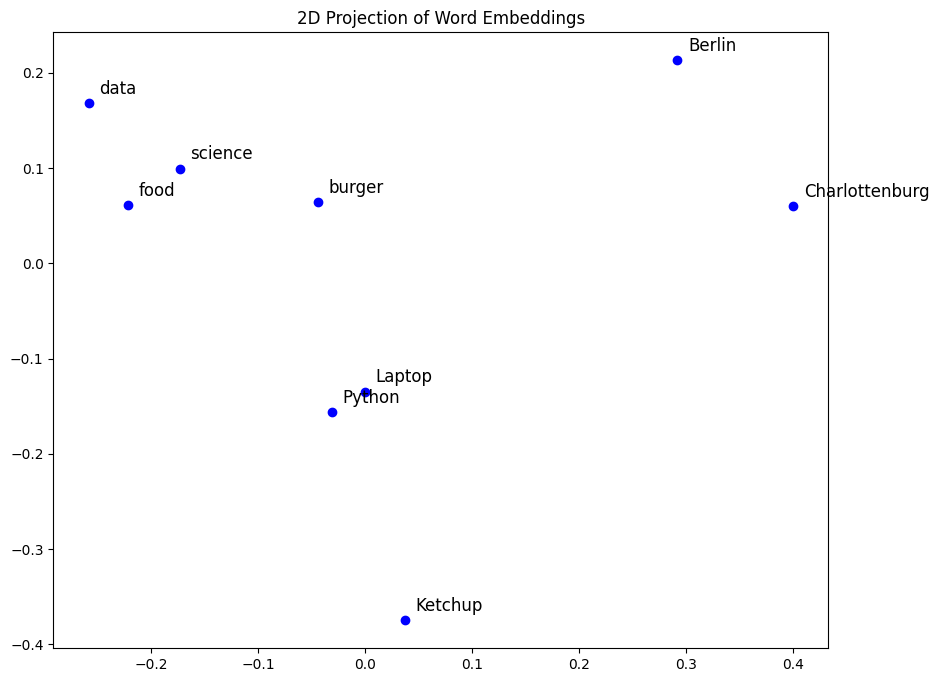

In [44]:
# visualise embedding in 2D
import numpy as np
import matplotlib.pyplot as plt
from huggingface_hub import InferenceClient
from sklearn.decomposition import PCA

# Words to embed
words = ["food", "burger", "data", "science", "Laptop", "Python","Berlin", "Charlottenburg","Ketchup"]
embeddings = {}

# Generate embeddings
for word in words:
    embeddings[word] = embedding_client.feature_extraction(
        word,
        model="intfloat/multilingual-e5-large",
    )

# Prepare data for PCA
all_vectors = np.array(list(embeddings.values()))
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(all_vectors)

# Plot the results
plt.figure(figsize=(10, 8))
for i, word in enumerate(embeddings.keys()):
    x, y = reduced_vectors[i]
    plt.scatter(x, y, marker='o', color='blue' )
    plt.text(x + 0.01, y + 0.01, word, fontsize=12, color='black' if word != "king - queen + female" else 'red')

plt.title("2D Projection of Word Embeddings")
plt.show()

